# 💧 Predicting Water Pump Functionality in Tanzania

This notebook builds a classification model to predict whether a water pump is:

- **Functional**
- **Non-functional**
- **Functional but needs repair**

We'll explore, clean, and model the data using standard machine learning techniques. The goal is to assist local governments and NGOs in identifying water pumps that require maintenance or replacement — improving access to clean water across Tanzania.

---

## 📌 Project Workflow

1. **Import libraries & install dependencies**
2. **Load and explore the data**
3. **Clean and preprocess features**
4. **Train and evaluate models**
5. **Generate final predictions**

---

**📂 Data Source**: [DrivenData Water Table Challenge](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/)  
**🎯 Objective**: Build a multiclass classification model to predict pump functionality.

---


## ⚙️ Step 1: Set Up the Environment

In [2]:
%%capture
!pip install category_encoders==2.*
!pip install ydata_profiling==4.*

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Modeling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Preprocessing
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# EDA profiling
from ydata_profiling import ProfileReport


c:\Users\UserOne\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os


## 📂 Loading the Dataset

In this step, we load the raw data files into pandas DataFrames:

- `train_features.csv` — contains features describing each water pump.
- `train_labels.csv` — contains the corresponding pump status labels.
- `test_features.csv` — features for the test set, which we'll use for final predictions.


In [42]:
train_features = pd.read_csv("data/train_features.csv")
train_labels = pd.read_csv("data/train_labels.csv")
test_features = pd.read_csv("data/test_features.csv")

## 🔗 Merging Training Features and Labels

We merge the training features and labels into a single DataFrame `train` using their common keys.  
This combined dataset will be used for feature engineering and model training.

We also reload the test features separately for later use in generating predictions.

In [44]:
train = pd.merge(train_features, train_labels)
X_test = pd.read_csv ('data/test_features.csv')

## 🧹 Data Wrangling Function: `wrangle`

This function cleans the input DataFrame by:

- Dropping high-cardinality categorical columns (those with more than 100 unique values),  
  which often add noise or cause overfitting in models.

- Removing duplicate columns based on the first 100 rows to avoid redundant data.

> *Note:* The line to drop the `recorded_by` column is currently commented out but can be activated if needed.

The function returns a cleaned DataFrame ready for further processing.

In [45]:
def wrangle(df):
    # Drop constant columns
    #df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)


    return df


## 🔄 Applying Data Wrangling

We apply the `wrangle` function to both the training dataset and the test features.  
This ensures consistent cleaning and preparation of both datasets before modeling.


In [46]:
train = wrangle(train)
X_test = wrangle(test_features)

## 🎯 Define Features and Target Variable

- The target variable we want to predict is `status_group` (pump functionality status).  
- We separate it as `y` (labels) and keep the remaining columns as features `X` for model training.

In [47]:
target = 'status_group'
y= train[target]
X= train.drop(columns=target)

## 🧪 Train-Validation Split

We split the dataset into training and validation sets to evaluate model performance on unseen data.

- 80% of the data will be used for training (`X_train`, `y_train`).
- 20% will be held out for validation (`X_val`, `y_val`).

Using a fixed `random_state` ensures reproducibility of the split.


In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2,
                                                  random_state=42 )

## 🎯 Baseline Accuracy

Before building any models, we calculate the baseline accuracy —  
the accuracy you'd get by always predicting the most frequent class in the training set.

This serves as a minimum benchmark that our model should outperform.


In [49]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5440867003367004


## 🌳 Training a Decision Tree Model

We build a machine learning pipeline that includes:

- **Ordinal Encoding** for categorical variables,
- **Imputation** of missing values with the mean strategy,
- A **Decision Tree Classifier** as our first model.

The pipeline is then trained on the training data.


In [50]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)

model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_ty...
communal standpipe             2
communal standpipe multiple    3
other                          4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
other                 3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

## 📊 Model Performance Evaluation

We evaluate the Decision Tree model by calculating accuracy scores on:

- The **training set** to check how well the model learned the training data.
- The **validation set** to assess how well the model generalizes to unseen data.

Comparing these scores helps identify if the model is overfitting or underfitting.

In [13]:
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.7442129629629629


## 🌲 Exploring Decision Tree Depth Impact

We examine how the maximum depth of the Decision Tree affects performance by:

- Training models with tree depths ranging from 10 to 21.
- Recording training and validation accuracy for each depth.

This helps us understand the trade-off between underfitting (too shallow) and overfitting (too deep).

In [14]:
model_dt.named_steps['decisiontreeclassifier'].get_depth()

depths = range(10,22, 1)

train_acc = []
val_acc = []

for depth in depths:
    tree_model = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        DecisionTreeClassifier(max_depth = depth, random_state = 42)
    )
    tree_model.fit(X_train, y_train)
    train_acc.append(tree_model.score(X_train, y_train))
    val_acc.append(tree_model.score(X_val, y_val))

## 📈 Accuracy Scores by Tree Depth

Here are the training and validation accuracy scores recorded for each tested tree depth.  
We’ll use these to identify the optimal depth balancing bias and variance.

In [15]:
print (train_acc)
print(val_acc)

[0.7745949074074074, 0.7903251262626263, 0.8065025252525253, 0.8249684343434344, 0.8437763047138047, 0.8626104797979798, 0.8822337962962963, 0.8988846801346801, 0.9146675084175084, 0.9296085858585859, 0.9435763888888888, 0.9560185185185185]
[0.7471590909090909, 0.7550505050505051, 0.76010101010101, 0.7611531986531986, 0.7683080808080808, 0.7658880471380471, 0.7643097643097643, 0.7612584175084175, 0.7606271043771043, 0.7583122895622896, 0.7566287878787878, 0.7557870370370371]


## 🔍 Feature Importance from Decision Tree

We extract and visualize the top 10 most important features based on the Decision Tree’s Gini importance scores.

This helps us understand which features contribute most to the model’s predictions.

C:\Users\UserOne\AppData\Local\Temp\ipykernel_4340\1365571861.py:1: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  features = model_dt.named_steps['ordinalencoder'].get_feature_names()


Text(0.5, 0, 'gini importance')

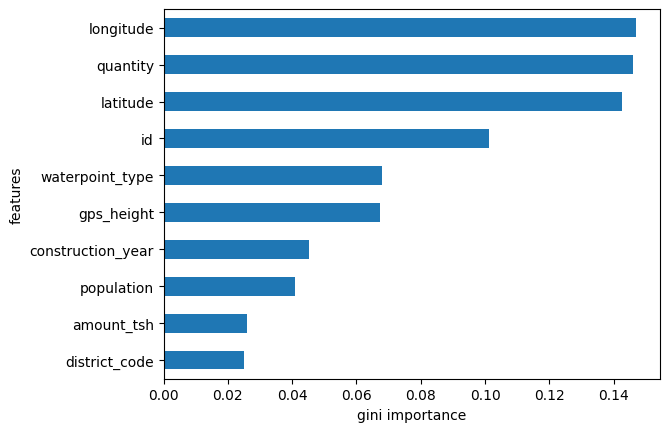

In [16]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini_importances = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
#or pd.DataFrame (feature_importance, columns = ['Features_Values], index
# = feature_names).sort_values(by= 'Feature_Values', ascending=False)
pd.Series(data=gini_importances, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance')

## 📦 New Packages for Modeling

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


## 🌳 Decision Tree Classification Pipeline

This pipeline sets up a basic Decision Tree model with preprocessing steps included:


In [18]:
clf_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state = 42)
)

## 🌲 Random Forest Classification Pipeline

This pipeline streamlines preprocessing and model fitting for a Random Forest classifier.

In [28]:
clf_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state = 42)
)

## ✅ Cross-Validation Scores: Decision Tree vs. Random Forest

We’re using `cross_val_score` from `sklearn.model_selection`.

In [27]:
cv_scores_dt = cross_val_score(clf_dt, X, y, cv=3, n_jobs = -1)
cv_scores_rf = cross_val_score(clf_rf, X, y, cv=3, n_jobs=-1)

## 💧 Decision Tree Model Performance on Water Pump Data

We tested our Decision Tree model to predict important outcomes about water pumps. When evaluated on three different subsets of the data, the model achieved accuracy scores of:

- Fold 1: **73.16%**  
- Fold 2: **73.16%**  
- Fold 3: **72.78%**

The **average accuracy** across all folds was **73.03%**, meaning the model correctly predicts about 73 out of 100 pumps.

The variation between these results was very small — only about **0.18%** — showing that the model’s predictions are steady and reliable across different data slices.

This indicates the model is a consistent and decent starting point for understanding and managing water pump performance.

In [21]:
print('CV scores DecisionTreeClassifier')
print(cv_scores_dt)
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV scores DecisionTreeClassifier
[0.73162879 0.73156566 0.72784091]
Mean CV accuracy score: 0.7303451178451178
STD CV accuracy score: 0.0017709305471354884


## 🌲 Random Forest Model Performance on Water Pump Data

We evaluated the Random Forest model on the water pump dataset using 3-fold cross-validation. The accuracy scores for each fold were:

- Fold 1: **79.23%**  
- Fold 2: **79.49%**  
- Fold 3: **79.83%**

The **average accuracy** was **79.52%**, meaning this model correctly predicts about 79 out of 100 pumps.

The standard deviation was approximately **0.25%**, indicating the model’s performance is consistent across different data splits.

Compared to the Decision Tree, the Random Forest shows better accuracy and similar stability, making it a stronger choice for predicting water pump outcomes.


### 🤝 Comparison to Decision Tree Model

- The Decision Tree model had an average accuracy of **73.03%** with a very low variation of **0.18%**.
- The Random Forest improves on this with about **6.5% higher accuracy** (79.52%) while maintaining similar consistency.
- This means the Random Forest is both **more accurate** and **equally reliable** for predicting water pump outcomes, making it a stronger choice overall.

---

This comparison suggests that using the ensemble Random Forest model can help better understand and manage water pump performance.

In [26]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.79229798 0.79488636 0.79829545]
Mean CV accuracy score: 0.7951599326599327
STD CV accuracy score: 0.0024560884680920156


## 🔧 Hyperparameter Grid for Random Forest Tuning

We define a grid of hyperparameters to search over during model tuning.

In [24]:
param_grid={
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__max_depth':range(5,40,5),
    'randomforestclassifier__n_estimators': range(25,125,25)
}

## 🔎 Randomized Search for Hyperparameter Tuning

We use `RandomizedSearchCV` to efficiently explore different combinations of hyperparameters for the Random Forest pipeline.

In [32]:
model = RandomizedSearchCV(
    clf_rf ,
    param_distributions = param_grid,
    n_jobs =-1,
    verbose =1,
    n_iter = 25,
    cv = 3
)

## 🚀 Fitting the Model

We now train (`fit`) the `RandomizedSearchCV` model on our dataset.

In [35]:
model.fit(X,y)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 40, 5),
                                        'randomforestclassifier__n_estimators': range(25, 125, 25),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

## 🎯 Best Model Results from Hyperparameter Search

After fitting, we can retrieve and display the best cross-validation score and corresponding hyperparameters.

In [36]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.7994949494949495
Best params for `model`: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 75, 'randomforestclassifier__max_depth': 20}


## 🧪 Generating Predictions and Preparing Submission

After training and tuning our model, we use it to predict outcomes on the test dataset.

In [40]:
y_pred = model.predict(X_test)
predictions = pd.DataFrame({'status_group': y_pred}, index=X_test.index)

In [ ]:
predictions.to_csv('output/predictions.csv')